# Theory

In a simple stereo system with two parallel cameras at the same height and with the same focal length $f$ and baseline $B$, the projection of a 3D point $P$ onto the left image plane is given by $p_l = (u, v)$. Let $p_r = (u', v')$ be the projection of the same point onto the right image plane.

Since the cameras are parallel and at the same height, the optical axes of both cameras are parallel to each other and lie on the same horizontal plane. This means that the $v$ coordinate of $p_l$ and the $v'$ coordinate of $p_r$ are equal, i.e., $v = v'$.

The horizontal disparity between the two projections is given by $d = u - u'$. Using similar triangles, we can derive that $d = \frac{Bf}{Z}$, where $Z$ is the depth of point $P$ along the optical axis. This equation shows that the disparity between the two projections is inversely proportional to the depth of the point.

In summary, in a simple stereo system with parallel cameras at the same height, the projection of a 3D point onto the right image plane lies on a horizontal line having the same vertical coordinate as its projection onto the left image plane. The horizontal disparity between the two projections is inversely proportional to the depth of the point.

The observation that corresponding points in a stereo system lie on the same horizontal line can also be proved using the essential matrix.

The essential matrix $E$ encodes the epipolar geometry between two views and is defined as $E = [t]_x R$, where $R$ is the relative rotation between the two cameras and $[t]_x$ is the skew-symmetric matrix representing the cross product with the relative translation $t$ between the two cameras.

For a pair of corresponding points $p_l$ and $p_r$ in the left and right images, respectively, the epipolar constraint is given by ${p_r}^T E p_l = 0$. In a simple stereo system with parallel cameras at the same height, the relative rotation $R$ is the identity matrix and the relative translation $t$ is $\begin{bmatrix} B \\ 0 \\ 0 \end{bmatrix}$, where $B$ is the baseline between the two cameras. This means that the essential matrix is given by $E = [t]_x R = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & -B \\ 0 & B & 0 \end{bmatrix}$.

Let $p_l = \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}$ and $p_r = \begin{bmatrix} u' \\ v' \\ 1 \end{bmatrix}$ be a pair of corresponding points in homogeneous coordinates. Substituting these into the epipolar constraint equation above gives us ${v'} * B - v * B = 0$, which simplifies to ${v'} = v$. This shows that corresponding points in a simple stereo system with parallel cameras at the same height lie on the same horizontal line.


# Programming

### Simple stereo system (Task 1)


##### Load image

Text(0.5, 1.0, 'Right camera')

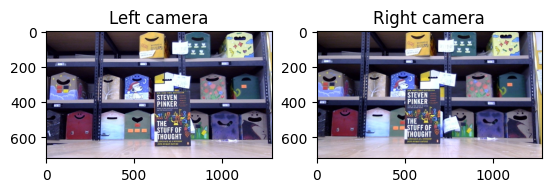

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('./Camera_data/Task_1/L_100.jpg')
imgR = cv2.imread('./Camera_data/Task_1/R_100.jpg')
plt.subplot(121); plt.imshow(imgL[:,:,::-1]); plt.title('Left camera')
plt.subplot(122); plt.imshow(imgR[:,:,::-1]); plt.title('Right camera')

##### Generate disparity map

Let's create a function that accepts two images of the simple stereo system and generate the disparity values

Firstly, let's resize the image to have a smaller size. Otherwise, it would need too much computational power.

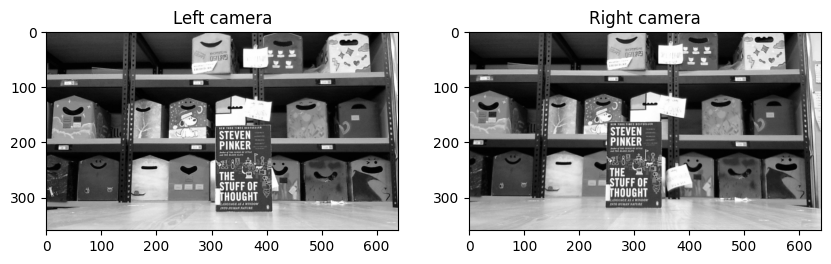

In [2]:
imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
imgL = cv2.resize(imgL, dsize=None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_LINEAR_EXACT)
imgR = cv2.resize(imgR, dsize=None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_LINEAR_EXACT)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(imgL, cmap='gray'); plt.title('Left camera')
plt.subplot(122); plt.imshow(imgR, cmap='gray'); plt.title('Right camera')
plt.show()

Next, we will generate the disparity value for both left image and right image. To do that, we will use openCV's stereoSGBM.
Please note that the signs of the disparity value of left image and right image are opposite to each other.

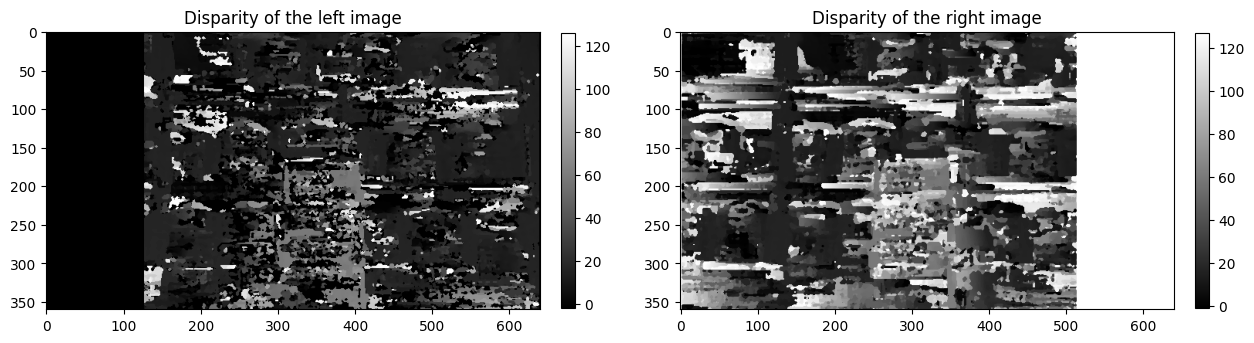

In [3]:
window_size = 5 
nDisp = 16*8

left_matcher = cv2.StereoSGBM_create(
    minDisparity=-1, # the disparity only goes in one direction
    numDisparities=nDisp, # each disparity value is multiplied with 16 to create better precision.
    blockSize=window_size, # the size of the block to compare
    P1=8 * 3 * window_size,
    P2=32 * 3 * window_size,
    disp12MaxDiff=12,
    uniquenessRatio=1,
    speckleWindowSize=5,
    speckleRange=5,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
displ = left_matcher.compute(imgL, imgR) #.astype(np.float32)/16
dispr = right_matcher.compute(imgR, imgL)  #.astype(np.float32)/16
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(displ.astype(np.float32)/16, cmap='gray'); plt.title('Disparity of the left image'); plt.colorbar(fraction=0.026, pad=0.04)
plt.subplot(122); plt.imshow(-dispr.astype(np.float32)/16, cmap='gray'); plt.title('Disparity of the right image'); plt.colorbar(fraction=0.026, pad=0.04)

##### Refining disparity map

As you have seen in the picture above, the disparity values are still noisy. This is because of texture-less areas, half-occlusions (pixels in which there are no correspondences) and regions near depth discontinuities (for example, the pixels on the edges of the books).

I use Weighted Least Squares filter to enhance the disparity map. The algorithm preserves the edges in the disparity map.

Text(0.5, 1.0, 'Refined disparity map')

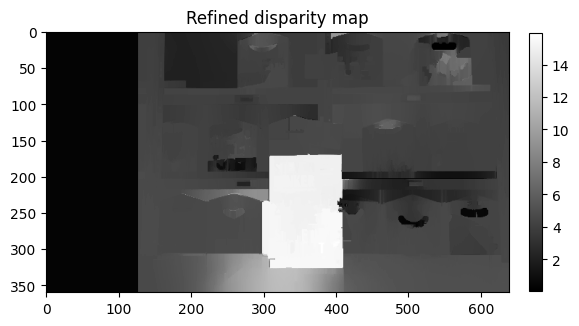

In [4]:
lmbda = 5000
sigma = 3

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)
displ = np.int16(displ)
dispr = np.int16(dispr)
filteredImg = wls_filter.filter(displ, imgL, None, dispr)
mean = np.mean(filteredImg[filteredImg != 0])
filteredImg[filteredImg == 0] = mean
filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=1, alpha=255, norm_type=cv2.NORM_MINMAX)
plt.imshow(filteredImg.astype(np.float32)/16, cmap='gray')
plt.colorbar(fraction=0.026, pad=0.04)
plt.title('Refined disparity map')

##### Calculate distance map


After having the disparity values, we can depth of a pixel. The depth is disproportionate to the disparity.

In [5]:
cam_matrix = np.array([[1379.4102426941595, 0.00000000e+00, 642.4893208443577],
                       [0.00000000e+00, 1377.1286103439993, 313.25739420496194],
                       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

base_line = 0.35 #distance between two cameras in meter
f = cam_matrix[0][0] * 0.5 # we multiply the f value because we resize the image into half
depth = np.zeros_like(filteredImg)
depth = base_line * f / filteredImg
print(depth[300, 350]) # The pixel is on the surface of the book

0.9812877742743004


The distance between the camera to the book is indeed 1m.

##### Render 3D depth map

In [6]:
import open3d as o3d

def use_o3d(pts, colors, write_text):
    pcd = o3d.geometry.PointCloud()

    pcd.points = o3d.utility.Vector3dVector(pts)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # http://www.open3d.org/docs/release/python_api/open3d.io.write_point_cloud.html#open3d.io.write_point_cloud
    o3d.io.write_point_cloud("my_pts.ply", pcd, write_ascii=write_text)

    # read ply file
    pcd = o3d.io.read_point_cloud('my_pts.ply')

    # visualize
    o3d.visualization.draw_geometries([pcd])

orig_L = cv2.imread('./Camera_data/Task_1/L_100.jpg')
orig_L = cv2.resize(orig_L, dsize=None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR_EXACT)
coordinates = []
colors = []
for i in range(depth.shape[0]):
    for j in range(depth.shape[1]):
        if (j <= nDisp):
            continue
        coordinates.append([i, j, 300/depth[i, j]])
        colors.append(orig_L[:, :, ::-1][i, j])
colors = np.array(colors) / 255
coordinates = np.array(coordinates)
xyz = np.random.rand(3000, 3)
use_o3d(coordinates, colors, True)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


##### Check for near objects

For this subtask, I create a Region of Interest in the image and calculate the mean distance of that ROI. If the average distance is less than 0.8m, I create a warning

In [7]:
width = imgL.shape[1]
height = imgL.shape[0]
distance = np.array(depth[(height >> 1)-20:(height >> 1) + 20,(width >> 1)-20:(width >> 1) + 20][(depth[(height >> 1)-20:(height >> 1) + 20,(width >> 1)-20 :(width >> 1) + 20] != np.inf)]).mean()
distance

2.145082988871107

This implementation can run real-time with high fps performance

### Uncalibrated Stereo System (Task 2)

##### Load image


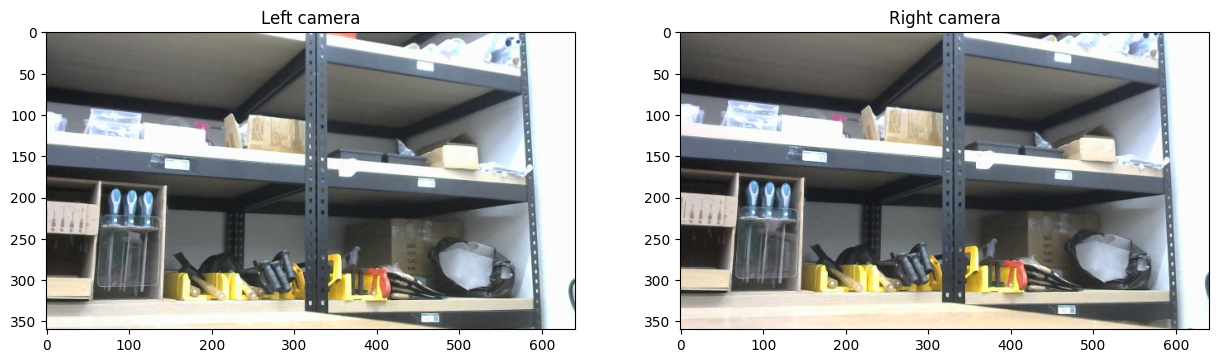

In [8]:
imgL = cv2.imread('./Camera_data/Task_2/imgL.jpg')
imgR = cv2.imread('./Camera_data/Task_2/imgR.jpg')
imgL = cv2.resize(imgL, dsize=None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR_EXACT)
imgR = cv2.resize(imgR, dsize=None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR_EXACT)

plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(imgL[:,:,::-1]); plt.title('Left camera')
plt.subplot(122); plt.imshow(imgR[:,:,::-1]); plt.title('Right camera')
imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

##### Rectify image

To rectify the image, we needed to find at least 5 correspondences between two images.

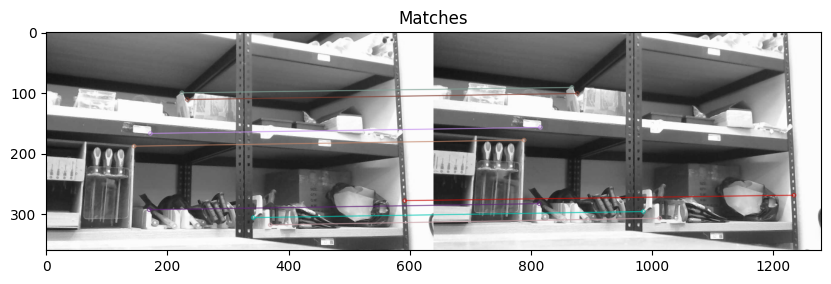

In [9]:
def get_keypoints_and_descriptors(imgL, imgR):

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(imgL, None)
    kp2, des2 = orb.detectAndCompute(imgR, None)

    ############## Using FLANN matcher ##############
    FLANN_INDEX_LSH = 6
    index_params = dict(
        algorithm=FLANN_INDEX_LSH,
        table_number=6,  # 12
        key_size=12,  # 20
        multi_probe_level=1,
    )  # 2
    search_params = dict(checks=50) 
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    flann_match_pairs = flann.knnMatch(des1, des2, k=2)
    return kp1, des1, kp2, des2, flann_match_pairs

def filter(matches, ratio_threshold=0.6):
    filtered_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            filtered_matches.append(m)
    return filtered_matches

def draw_matches(imgL, imgR, kp1, des1, kp2, des2, flann_match_pairs):
    """Draw the first 8 mathces between the left and right images."""
    # https://docs.opencv.org/4.2.0/d4/d5d/group__features2d__draw.html
    # https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html
    img = cv2.drawMatches(
        imgL,
        kp1,
        imgR,
        kp2,
        flann_match_pairs[:8],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.title('Matches')
    plt.show()
    cv2.imwrite("ORB_FLANN_Matches.png", img)
    cv2.waitKey(0)


kp1, des1, kp2, des2, flann_match_pairs = get_keypoints_and_descriptors(imgL, imgR)
good_matches = filter(flann_match_pairs, 0.6)
draw_matches(imgL, imgR, kp1, des1, kp2, des2, good_matches)   

Next, we need to calculate the fundamental matrix using the matches.

In [11]:
def compute_fundamental_matrix(matches, kp1, kp2, method=cv2.FM_RANSAC):

    pts1, pts2 = [], []
    fundamental_matrix, inliers = None, None
    for m in matches[:8]:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    if pts1 and pts2:
        fundamental_matrix, inliers = cv2.findFundamentalMat(
            np.float32(pts1),
            np.float32(pts2),
            method=method,
        )
    return fundamental_matrix, inliers, pts1, pts2
F, I, points1, points2 = compute_fundamental_matrix(good_matches, kp1, kp2)
F

array([[ 9.58252525e-20,  2.07296849e-04, -1.33913765e-01],
       [-2.07296849e-04, -3.06640808e-20,  4.64344942e-02],
       [ 1.31840796e-01, -4.72636816e-02,  1.00000000e+00]])

From the fundamental matrix, we can calibrate the stereo system

Text(0.5, 1.0, 'Right camera')

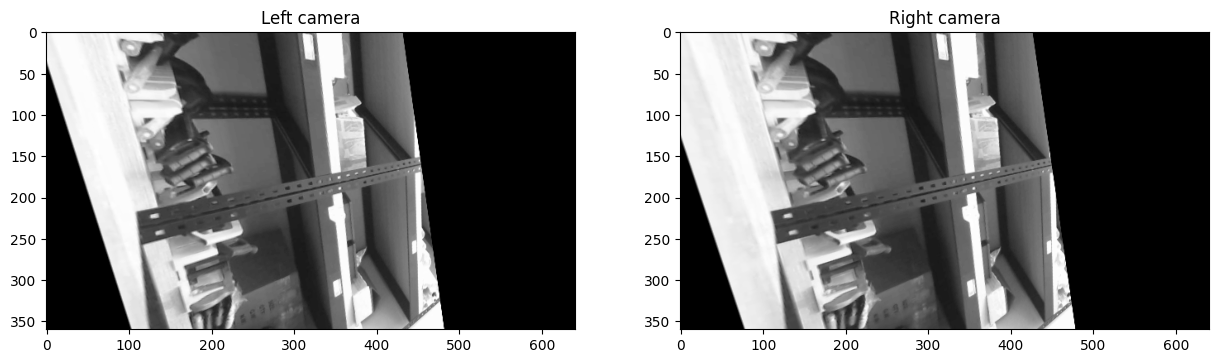

In [19]:
h1, w1 = imgL.shape
h2, w2 = imgR.shape
thresh = 0
_, H1, H2 = cv2.stereoRectifyUncalibrated(  
    np.float32(points1), np.float32(points2), F, imgSize=(w1, h1), threshold=thresh,
)
imgL_undistorted = cv2.warpPerspective(imgL, H1, (w1, h1))
imgR_undistorted = cv2.warpPerspective(imgR, H2, (w2, h2))

plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(imgL_undistorted, cmap='gray'); plt.title('Left camera')
plt.subplot(122); plt.imshow(imgR_undistorted, cmap='gray'); plt.title('Right camera')

##### Calculate disparity map

After rectifying the image, we can calculate the disparity map as in the simple stereo system

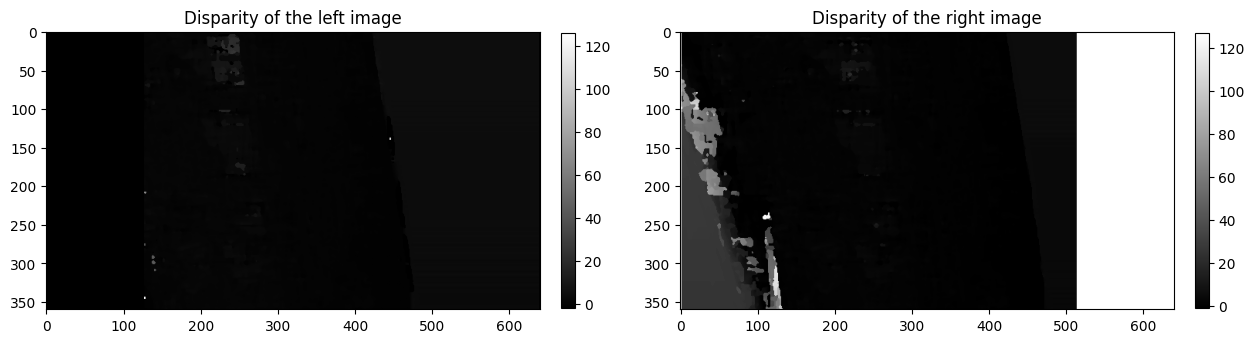

In [20]:
imgL = imgL_undistorted
imgR = imgR_undistorted
window_size = 5 
nDisp = 16*8

left_matcher = cv2.StereoSGBM_create(
    minDisparity=-1, # the disparity only goes in one direction
    numDisparities=nDisp, # each disparity value is multiplied with 16 to create better precision.
    blockSize=window_size, # the size of the block to compare
    P1=8 * 3 * window_size,
    P2=32 * 3 * window_size,
    disp12MaxDiff=12,
    uniquenessRatio=1,
    speckleWindowSize=5,
    speckleRange=5,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
displ = left_matcher.compute(imgL, imgR) #.astype(np.float32)/16
dispr = right_matcher.compute(imgR, imgL)  #.astype(np.float32)/16
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(displ.astype(np.float32)/16, cmap='gray'); plt.title('Disparity of the left image'); plt.colorbar(fraction=0.026, pad=0.04)
plt.subplot(122); plt.imshow(-dispr.astype(np.float32)/16, cmap='gray'); plt.title('Disparity of the right image'); plt.colorbar(fraction=0.026, pad=0.04)

Text(0.5, 1.0, 'Refined disparity map')

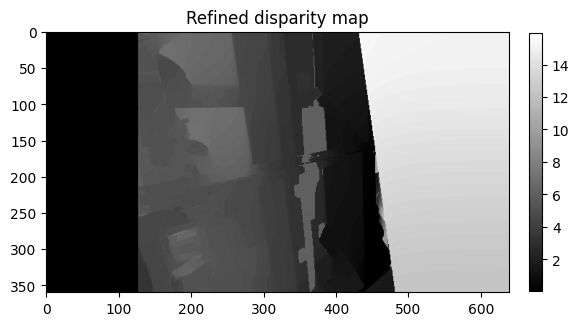

In [21]:
lmbda = 5000
sigma = 3

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)
displ = np.int16(displ)
dispr = np.int16(dispr)
filteredImg = wls_filter.filter(displ, imgL, None, dispr)
mean = np.mean(filteredImg[filteredImg != 0])
filteredImg[filteredImg == 0] = mean
filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=1, alpha=255, norm_type=cv2.NORM_MINMAX)
plt.imshow(filteredImg.astype(np.float32)/16, cmap='gray')
plt.colorbar(fraction=0.026, pad=0.04)
plt.title('Refined disparity map')